<a href="https://colab.research.google.com/github/erinnfairley/SSC-Remote-Sensing-Fraser-River/blob/main/SSCRemoteSensing_cleancode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Import libraries
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import geemap


import ee # authenticating GEE
ee.Authenticate()

True

In [137]:
plt.rcParams['font.size'] = 13 # Globally setting default font size for plots for visibility on presentation

In [2]:
ee.Initialize(project='geog606-erinnfairley') # find project IDs at console.cloud.google.com

In [3]:
from google.colab import drive
drive.mount('/content/drive') #connecting my Drive

Mounted at /content/drive


In [4]:
# Define the region of interest (ROI)
roi_polygon = ee.Geometry.Polygon([[
    [ -122.30149952643202, 49.12846235218844], [-122.29364846851334, 49.13177652947345], [-122.29035485397183, 49.12868163352204], [-122.29702825320271, 49.125360983763784]
]]) # Creating geographic boundary around Fraser River gage

In [36]:
# Load Landsat 5 Surface Reflectance dataset to check individual photos -- helps characterize outliers later
# You have to input a range of dates, so if you want to focus on one day, input
# first day and the day after
dataset = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
            .filterDate('1992-08-17', '1992-08-18') \
            .filterBounds(roi_polygon)

# Use this code to sample only the first image (your day of interest)
image = dataset.first()

# Obtained directly from GEE Landsat site, to visualize raw imagery
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B6').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )


dataset = dataset.map(apply_scale_factors)

visualization = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0.0,
    'max': 0.3,
}

# Creating map out of definitions above
m = geemap.Map()
m.add_layer(dataset, visualization, 'True Color (321)')
m.add_layer(roi_polygon, {'color':'red'}, name='ROI') # this creates a polygon on the map in red to be able to zoom in on ROI easily
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [6]:
# I am creating a loop function to read in the Landsat 5 data, and read each year of image collections separately, apply my add_date function,
# merge them all into a single collection, use the sampled pixel values I defined, and then convert this into a data frame, with date-time as an index,
# and add columns of scaled SR values for Bands 3 and 4 (red and NIR). I also aggregate the images using the median value, because there are multiple
# images captured on each day.

# year range
start_year = 1984
end_year = 1992

# creating a list to hold all dfs
L5_yearly_data = []

# defining the add_date action, to add the date property to each image in the image collection
def add_date(image):
    # obtaining the image acquisition date, making it a string
    date = image.date().format('YYYY-MM-dd')

    # sample pixel values
    samples = image.sample(region=roi_polygon, scale=30, geometries=True) # geometries=True will maintain the geometry of where the sample was taken from

    # add date to each feature
    return samples.map(lambda feature: feature.set('date', date))

# creating a loop to perform all of the following functions, one year at a time
for year in range(start_year, end_year + 1): # for each year in the range of the start and end years defined above, +1 to include the last year
    print(f'Processing year: {year}')

    # reading in the Landsat 5 collection, filtering for ROI, cloud cover < 10%, Jan-Dec of each year, and all bands of interest
    landsat5_year = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
        .filterBounds(roi_polygon) \
        .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
        .filterDate(f'{year}-01-01', f'{year}-12-31') \
        .select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'SR_B1']) # selecting all bands for later regression analysis


    # continuing loop, sample each image and add date
    sampled_images = landsat5_year.map(add_date)

    # flatten the feature collection to merge all samples into a single collection
    all_samples = sampled_images.flatten()

    # get sampled pixel values and properties as a list of dictionaries
    samples_dict = all_samples.getInfo()

    # this is a check to ensure the features transferred correctly over to the dictionary, and if they did, create a df
    if 'features' in samples_dict:
        # Convert the data to df
        year_data = pd.DataFrame([feature['properties'] for feature in samples_dict['features']])

        # apply scale factor to convert reflectance to the correct range; this comes from the GEE dataset info
        year_data['Green'] = year_data['SR_B2'] * 0.0000275 + (-0.2)
        year_data['Red'] = year_data['SR_B3'] * 0.0000275 + (-0.2)
        year_data['NIR'] = year_data['SR_B4'] * 0.0000275 + (-0.2)
        year_data['SWIR1'] = year_data['SR_B5'] * 0.0000275 + (-0.2)
        year_data['SWIR2'] = year_data['SR_B7'] * 0.0000275 + (-0.2)
        year_data['Blue'] = year_data['SR_B1'] * 0.0000275 + (-0.2)

        # include date in df and set it as index
        year_data['date'] = pd.to_datetime(year_data['date'])
        year_data.set_index('date', inplace=True)

        # aggregate by date (median)
        year_data = year_data.groupby(year_data.index).median()

        # append this year's df to the list
        L5_yearly_data.append(year_data)

        # preview of the df
        print(f'Year {year} DataFrame head:')
        print(year_data[['Blue','Green', 'Red', 'NIR']].head())
    else:
        print(f'No samples found for year {year}.')

# combine each year df into one df,
# including if else check to make sure everything translated properly
if L5_yearly_data:
    landsat5 = pd.concat(L5_yearly_data)
    print('Combined DataFrame head:')
    print(landsat5.head())
else:
    print("No data to concatenate.")


Processing year: 1984
Year 1984 DataFrame head:
                Blue     Green       Red       NIR
date                                              
1984-07-19  0.067410  0.102693  0.088008  0.048930
1984-09-28  0.063285  0.094140  0.089190  0.046703
Processing year: 1985
Year 1985 DataFrame head:
                Blue     Green       Red       NIR
date                                              
1985-02-03  0.052808  0.052175  0.039222  0.027150
1985-03-07  0.044832  0.057648  0.054100  0.040763
1985-03-16  0.047995  0.056327  0.050250  0.035895
1985-08-14  0.070545  0.104673  0.088915  0.058692
1985-08-23  0.061745  0.092958  0.070132  0.033475
Processing year: 1986
Year 1986 DataFrame head:
                Blue     Green       Red       NIR
date                                              
1986-05-29  0.060604  0.097715  0.100465  0.077722
1986-08-01  0.071865  0.106391  0.086935  0.059160
1986-08-26  0.061167  0.087430  0.068647  0.034933
Processing year: 1987
Year 1987 DataFram

In [22]:
# To download clean Landsat df to computer
landsat5.to_csv('Landsat5_clean.csv', index=True)  # index=True to keep date as separate column

from google.colab import files

# Download the CSV file to your local machine
files.download('Landsat5_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Now we have a df combined with each image date between 1984-1992 and their corresponding band surface reflectance values, taking the median
# of these values for each image date.

# We want to now use this df to compute SSC concentrations, which requires using real SSC values to build an algorithm

In [7]:
# Importing actual SSC data from Environment Canada, gage station at Mission on the Fraser River

from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

allreal_SSC = pd.read_csv(io.BytesIO(uploaded['SSC_FraserMission_19651992.csv'])) # replace your_file.csv with your file name

Saving SSC_FraserMission_19651992.csv to SSC_FraserMission_19651992.csv


In [8]:
# Convert date column because I know it's all mixed formats, using 'coerce' to fix this
allreal_SSC['Date'] = pd.to_datetime(allreal_SSC['Date'], format='mixed', errors='coerce', dayfirst=True)

# Checking if any dates weren't converted correctly
print(allreal_SSC[allreal_SSC['Date'].isna()])

Empty DataFrame
Columns: [ ID, PARAM, Date, Concentration, SYM]
Index: []


In [9]:
# Final check df looks good
allreal_SSC.head()

,ID,PARAM,Date,Concentration,SYM
0,08MH024,3,1965-01-06,630,S
1,08MH024,3,1965-02-06,735,S
2,08MH024,3,1965-03-06,700,S
3,08MH024,3,1965-04-06,535,S
4,08MH024,3,1965-05-06,470,S


In [37]:
# Joining Landsat and sediment datasets, keeping only the dates that align
# Merging dfs and keeping only matching dates
sediment_merged = pd.merge(landsat5, allreal_SSC, left_on='date', right_on='Date', how='inner', )

# don't need these columns
sediment_merged = sediment_merged.drop(columns=['SR_B7','SR_B1', 'SR_B5','SR_B2', 'SR_B3', 'SR_B4', 'PARAM', 'SYM'])

# dropping one outlier I was able to identify
sediment_merged = sediment_merged[sediment_merged['Date'] != '1987-07-28']

display(sediment_merged)

,Green,Red,NIR,SWIR1,SWIR2,Blue,ID,Date,Concentration
0,0.102693,0.088008,0.048930,0.012822,0.005205,0.067410,08MH024,1984-07-19,132
1,0.094140,0.089190,0.046703,0.012327,0.007873,0.063285,08MH024,1984-09-28,80
2,0.052175,0.039222,0.027150,0.008835,0.004930,0.052808,08MH024,1985-02-03,25
3,0.057648,0.054100,0.040763,0.017580,0.008835,0.044832,08MH024,1985-03-07,100
4,0.056327,0.050250,0.035895,0.015765,0.007845,0.047995,08MH024,1985-03-16,12
5,0.104673,0.088915,0.058692,0.022805,0.017662,0.070545,08MH024,1985-08-14,55
6,0.092958,0.070132,0.033475,0.005672,0.005700,0.061745,08MH024,1985-08-23,33
7,0.097454,0.087980,0.046345,0.006772,0.001740,0.060837,08MH024,1985-09-24,46
8,0.067685,0.046207,0.027535,0.008890,0.004930,0.044393,08MH024,1985-11-11,2
9,0.300885,0.282653,0.225453,0.045685,0.036362,0.268284,08MH024,1985-11-27,3


In [38]:
# Create a column of the ln of Concentration in sediment_merged, will use for regression analysis

sediment_merged['ln_Concentration'] = np.log(sediment_merged['Concentration'])

sediment_merged.head()

,Green,Red,NIR,SWIR1,SWIR2,Blue,ID,Date,Concentration,ln_Concentration
0,0.102693,0.088008,0.048930,0.012822,0.005205,0.067410,08MH024,1984-07-19,132,4.882802
1,0.094140,0.089190,0.046703,0.012327,0.007873,0.063285,08MH024,1984-09-28,80,4.382027
2,0.052175,0.039222,0.027150,0.008835,0.004930,0.052808,08MH024,1985-02-03,25,3.218876
3,0.057648,0.054100,0.040763,0.017580,0.008835,0.044832,08MH024,1985-03-07,100,4.605170
4,0.056327,0.050250,0.035895,0.015765,0.007845,0.047995,08MH024,1985-03-16,12,2.484907


In [40]:
# Multiple regression for the bands and actual SSC, to determine equation to predict SSC
# Can perform this twice to also find equation for ln(SSC)

# Define dependent/independent variables
x = sediment_merged[['Green', 'Red', 'NIR']]
y = sediment_merged[['Concentration']]

from sklearn.model_selection import train_test_split # used to perform multiple linear regression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = None, random_state = 100) # usually would group data into train and test to make sure...
# ...model can work with data it hasn't seen before, but we ignore that here

# import LinearRegression class from sklearn.linear_model
from sklearn.linear_model import LinearRegression

# fit the MLR model
mlr = LinearRegression()
mlr.fit(x_train, y_train)

# this will print out the intercept and coefficients for each x variable
print("Intercept: ", mlr.intercept_)
print("Coefficients:")
list(zip(x, mlr.coef_))

# this is to make sure each coeff printed is shown next to its corresponding variable to avoid confusion
for feature, coef in zip(x.columns, mlr.coef_[0]):
  print(f'{feature}: {coef}')

Intercept:  [158.95470831]
Coefficients:
Green: -8267.002451392978
Red: 8480.763425533953
NIR: 68.75210372604488


In [41]:
# Inputting SSC algorithm for Landsat 5 data, using both regular SSC and ln(SSC) equations

# Adding column for both predicted SSC

sediment_merged['SSC_predicted'] = -8267.00 * sediment_merged['Green'] + 8480.76 * sediment_merged['Red'] + 68.75 * sediment_merged['NIR'] + 158.95
sediment_merged['lnSSC_predicted'] = -99.39*sediment_merged['Green'] + 110.10*sediment_merged['Red'] - 11.13*sediment_merged['NIR'] + 4.50

sediment_merged.head()

,Green,Red,NIR,SWIR1,SWIR2,Blue,ID,Date,Concentration,ln_Concentration,SSC_predicted,lnSSC_predicted
0,0.102693,0.088008,0.048930,0.012822,0.005205,0.067410,08MH024,1984-07-19,132,4.882802,59.725526,3.438427
1,0.094140,0.089190,0.046703,0.012327,0.007873,0.063285,08MH024,1984-09-28,80,4.382027,140.304401,4.443446
2,0.052175,0.039222,0.027150,0.008835,0.004930,0.052808,08MH024,1985-02-03,25,3.218876,62.122447,3.330545
3,0.057648,0.054100,0.040763,0.017580,0.008835,0.044832,08MH024,1985-03-07,100,4.605170,143.989655,4.273138
4,0.056327,0.050250,0.035895,0.015765,0.007845,0.047995,08MH024,1985-03-16,12,2.484907,121.916529,4.034623


In [207]:
# Downloading SSC df without discharge data first...
sediment_merged.to_csv('Sediment_merged.csv', index=True)

from google.colab import files

# downlaoding to local computer
files.download('Sediment_merged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Finally, uploading discharge data to determine any relationship between discharge and SSC

from google.colab import files
uploaded = files.upload()

discharge = pd.read_csv(io.BytesIO(uploaded['DailyDischarge_6522.csv']))
print(discharge)

Saving DailyDischarge_6522.csv to DailyDischarge_6522.csv
            ID  PARAM    Date   Value  SYM
0      08MH024    1.0  1/5/65  6200.0  NaN
1      08MH024    1.0  2/5/65  6400.0  NaN
2      08MH024    1.0  3/5/65  6310.0  NaN
3      08MH024    1.0  4/5/65  6030.0  NaN
4      08MH024    1.0  5/5/65  5640.0  NaN
...        ...    ...     ...     ...  ...
29044      NaN    NaN     NaN     NaN  NaN
29045      NaN    NaN     NaN     NaN  NaN
29046      NaN    NaN     NaN     NaN  NaN
29047      NaN    NaN     NaN     NaN  NaN
29048      NaN    NaN     NaN     NaN  NaN

[29049 rows x 5 columns]


In [42]:
# creating date-time and filtering dates to align with combined sediment df

discharge['Date'] = pd.to_datetime(discharge['Date'], format='mixed', errors='coerce', dayfirst=True)
discharge.loc[discharge['Date'].dt.year > 2022, 'Date'] -= pd.DateOffset(years=100)

start_date = pd.to_datetime('1984-01-01')
end_date = pd.to_datetime('1992-12-31')

filtered_discharge = discharge[(discharge['Date'] >= start_date) & (discharge['Date'] <= end_date)]

filtered_discharge.head()

,ID,PARAM,Date,Value,SYM
6819,08MH024,1.0,1984-01-01,1560.0,NaN
6820,08MH024,1.0,1984-01-02,1600.0,NaN
6821,08MH024,1.0,1984-01-03,1710.0,NaN
6822,08MH024,1.0,1984-01-04,3790.0,NaN
6823,08MH024,1.0,1984-01-05,4160.0,NaN


In [43]:
# Joining discharge with the full sediment df, keeping all discharge values from 1984-1992, and allowing NaNs for any SSC values

discharge_sediment = pd.merge(sediment_merged[['Concentration', 'Date', 'lnSSC_predicted', 'SSC_predicted', 'ln_Concentration']], # selecting the columns I want to keep
                              filtered_discharge[['Date', 'Value']], # selecting columns to keep
                              left_on='Date', right_on='Date', how='right') # keeping all discharge values and allowing nas for SSC

display(discharge_sediment)

,Concentration,Date,lnSSC_predicted,SSC_predicted,ln_Concentration,Value
0,NaN,1984-01-01,NaN,NaN,NaN,1560.0
1,NaN,1984-01-02,NaN,NaN,NaN,1600.0
2,NaN,1984-01-03,NaN,NaN,NaN,1710.0
3,NaN,1984-01-04,NaN,NaN,NaN,3790.0
4,NaN,1984-01-05,NaN,NaN,NaN,4160.0
...,...,...,...,...,...,...
3283,NaN,1992-12-27,NaN,NaN,NaN,1060.0
3284,NaN,1992-12-28,NaN,NaN,NaN,975.0
3285,NaN,1992-12-29,NaN,NaN,NaN,931.0
3286,NaN,1992-12-30,NaN,NaN,NaN,850.0


In [44]:
# export fully combined df to computer
discharge_sediment.to_csv('Sediment_Discharge.csv', index=True)

from google.colab import files

# downlaoding to local computer
files.download('Sediment_Discharge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [204]:
# Creating a summary table giving stats grouped by entire year, for each SSC category
# Ordering it so the predicted vs observed stats are beside each other

sediment_merged['Year'] = sediment_merged['Date'].dt.year # extracting the year

summary_stats = sediment_merged.groupby('Year').agg({
    'Concentration': ['median', 'min', 'max', 'count'],
    'SSC_predicted': ['median', 'min', 'max', 'count'],
    'ln_Concentration': ['median', 'min', 'max', 'count'],
    'lnSSC_predicted': ['median', 'min', 'max', 'count']})  # Fill NaNs with 0, or use .fillna(method='ffill') to propagate last valid observation forward

display(summary_stats)

Concentration                SSC_predicted                               \
            median min  max count        median        min         max count   
Year                                                                           
1984         106.0  80  132     2    100.014963  59.725526  140.304401     2   
1985          29.0   2  100     8     73.132013 -12.451346  143.989655     8   
1986          31.0  10  468     3     20.755657  20.750771  208.503070     3   
1987          22.0   5  274     9     60.785019   2.983136  144.193769     9   
1988          29.0   2   61     4     19.828031  12.077586  165.177961     4   
1989          29.0   3   55     2     62.154863  61.991523   62.318203     2   
1990          28.0  14  294     6     17.312194 -21.995403  148.348596     6   
1991          99.0  22  318    11    139.683355 -26.442891  262.990414    11   
1992          60.5  28  259     6     91.523273 -19.695704  190.036705     6   

     ln_Concentration                           lnSSC_predicted            \
               median       min       max count          median       min   
Year                                                                        
1984         4.632414  4.382027  4.882802     2        3.940936  3.438427   
1985         3.357692  0.693147  4.605170     8        3.281719  2.553769   
1986         3.433987  2.302585  6.148468     3        2.979623  2.838866   
1987         3.091042  1.609438  5.613128     9        3.251832  2.810485   
1988         2.687639  0.693147  4.110874     4        2.958909  2.380088   
1989         2.552973  1.098612  4.007333     2        3.511888  3.472281   
1990         3.321895  2.639057  5.683580     6        3.007453  2.404966   
1991         4.595120  3.091042  5.762051    11        4.408722  2.233276   
1992         3.986922  3.332205  5.556828     6        3.329426  2.366761   

                      
           max count  
Year                  
1984  4.443446     2  
1985  4.273138     8  
1986  4.984251     3  
1987  4.263325     9  
1988  4.618704     4  
1989  3.551494     2  
1990  4.624119     6  
1991  5.704290    11  
1992  4.679801     6

In [205]:
# Downloading summary table

from google.colab import files

# Assuming 'summary_stats' is the DataFrame you want to download
summary_stats.to_csv('summary_stats.csv', index=True)

# Download the CSV file to your local machine
files.download('summary_stats.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Now we have Landsat data used to predict SSC data, real SSC data, and real discharge data
# Time to create plots...

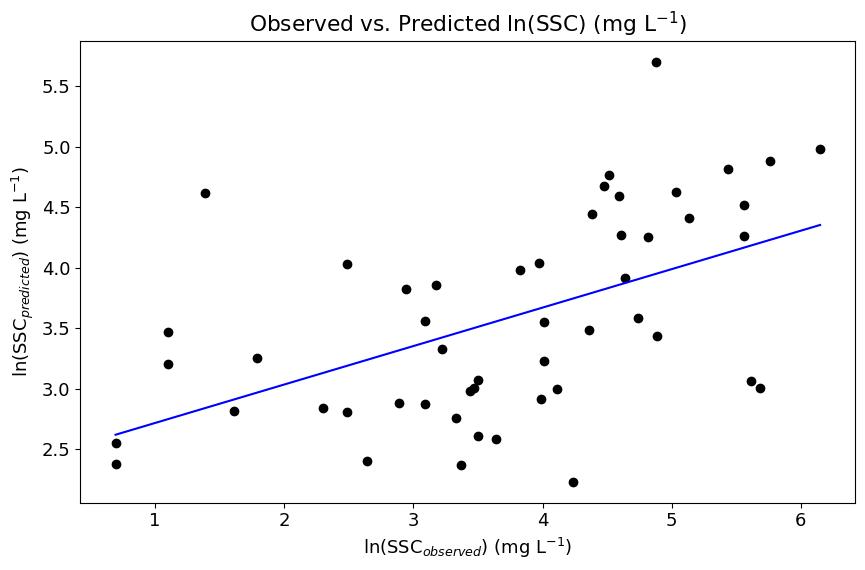

In [208]:
# Plot for ln(SSC) concentrations with trendline
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(sediment_merged['ln_Concentration'], sediment_merged['lnSSC_predicted'], color='black')
slope, intercept = np.polyfit(sediment_merged['ln_Concentration'], sediment_merged['lnSSC_predicted'], 1)
x_values = np.linspace(sediment_merged['ln_Concentration'].min(), sediment_merged['ln_Concentration'].max(), 100)
y_values = slope * x_values + intercept
ax.plot(x_values, y_values, color='blue', label='Trendline') # plots the trendline
ax.set_xlabel('ln(SSC$_{observed}$) (mg L$^{-1}$)')
ax.set_ylabel(r'ln(SSC$_{predicted}$) (mg L$^{-1}$)', color='black')  # Subscript using LaTeX notation
ax.set_title('Observed vs. Predicted ln(SSC) (mg L$^{-1}$)')
ax.tick_params('y', labelcolor='black')

plt.show()

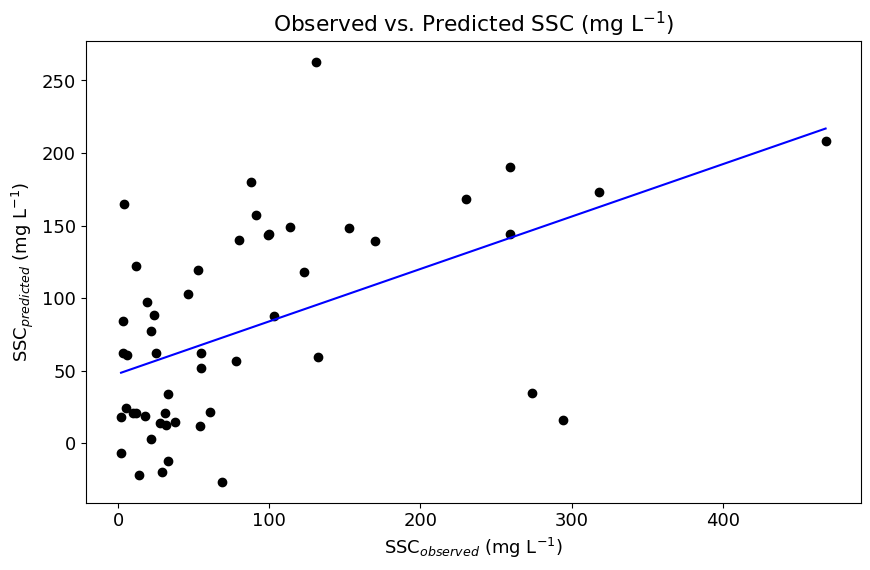

In [209]:
# Plot for regular SSC concentrations
fig, ax = plt.subplots(figsize=(10,6))

# 1st axis for actual ssc
ax.scatter(sediment_merged['Concentration'], sediment_merged['SSC_predicted'], color='black')

# Fit a linear trendline
slope, intercept = np.polyfit(sediment_merged['Concentration'], sediment_merged['SSC_predicted'], 1)
# Create a line using the slope and intercept
x_values = np.linspace(sediment_merged['Concentration'].min(), sediment_merged['Concentration'].max(), 100)
y_values = slope * x_values + intercept

# Plot the trendline
ax.plot(x_values, y_values, color='blue', label='Trendline')
ax.set_xlabel('SSC$_{observed}$ (mg L$^{-1}$)')
ax.set_ylabel(r'SSC$_{predicted}$ (mg L$^{-1}$)', color='black')
ax.set_title('Observed vs. Predicted SSC (mg L$^{-1}$)')
ax.tick_params('y', labelcolor='black')

plt.show()

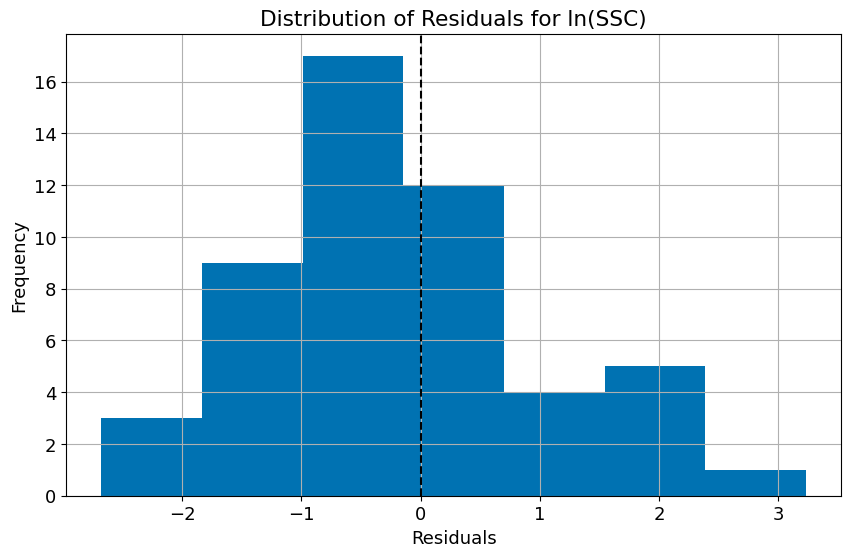

In [140]:
# Histogram of residuals for each of the above plots

import seaborn as sns
colorblind_colors = ['#0072B2', '#D95F02', '#E41A1C', '#F46D43', '#984EA3', '#A65628', '#999999'] # just trying out some different colors

plt.figure(figsize=(10,6))

plt.hist(sediment_merged['lnSSC_predicted'] - sediment_merged['ln_Concentration'],
         bins = 7, color=colorblind_colors[0]) # creating residual formula, setting number of bins based on # of data points
plt.axvline(0, linestyle='--', color='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals for ln(SSC)')
plt.grid(True)
plt.show()

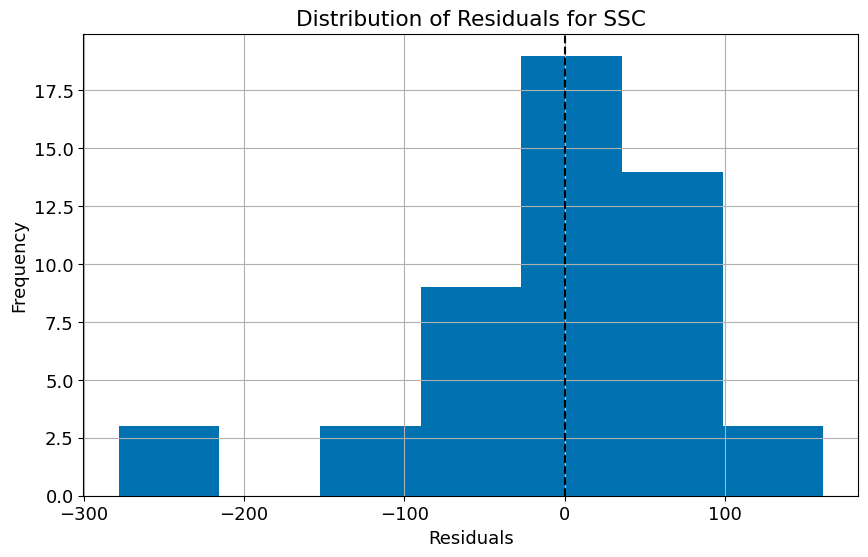

In [149]:
# Histogram of residuals

plt.figure(figsize=(10,6))

plt.hist(sediment_merged['SSC_predicted'] - sediment_merged['Concentration'],
         bins = 7, color=colorblind_colors[0])
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals for SSC')
plt.grid(True)
plt.show()

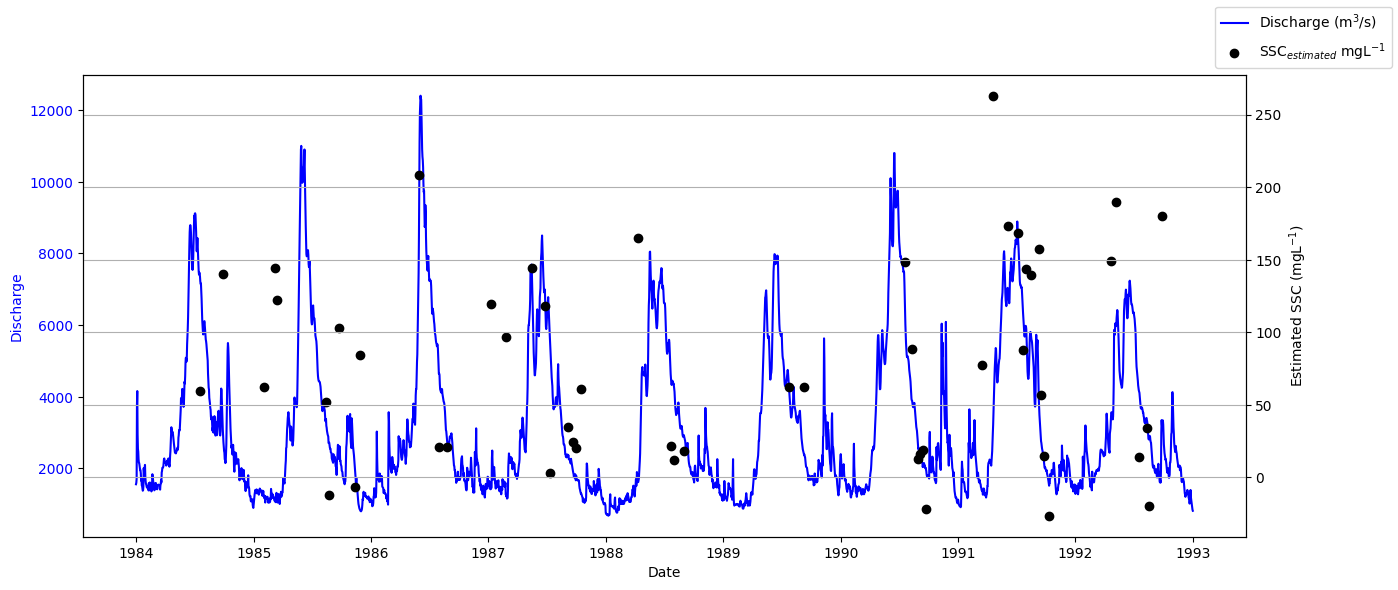

In [49]:
# SSC vs Discharge; using to find outliers in predicted values, may or may not use in presentation
fig, ax1 = plt.subplots(figsize=(15, 6))


ax1.plot(discharge_sediment['Date'], discharge_sediment['Value'], 'blue', label='Discharge (m$^{3}$/s)') # put dollar signs only around text you want
# elevated or subscripted, that way the whole word isn't italicized
ax1.set_xlabel('Date')
ax1.set_ylabel(r'Discharge', color='blue')
ax1.tick_params('y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.scatter(discharge_sediment['Date'], discharge_sediment['SSC_predicted'], color='black', label='SSC$_{predicted}$ mgL$^{-1}$')
ax2.set_ylabel(r'Predicted SSC (mgL$^{-1}$)', color='black')
ax2.tick_params('y', labelcolor='black')


fig.legend(loc='upper right')
plt.grid(True)
plt.show()

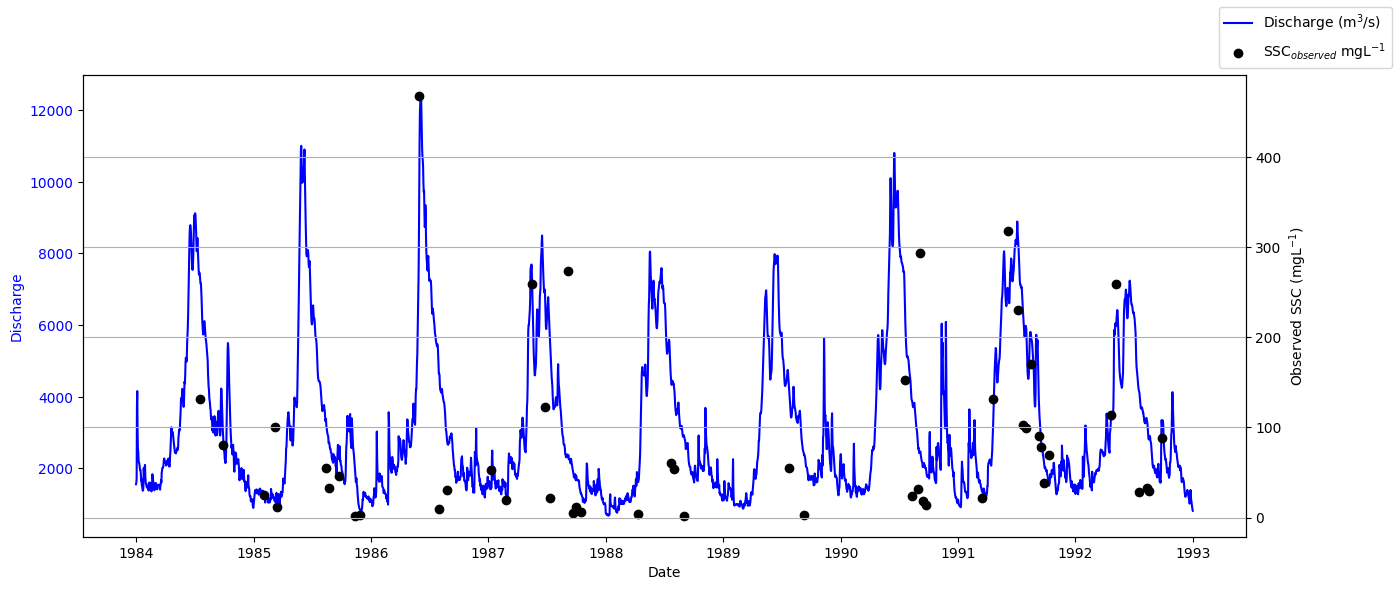

In [123]:
# Observed SSC vs Discharge; using to find outliers in predicted values
fig, ax1 = plt.subplots(figsize=(15, 6))


ax1.plot(discharge_sediment['Date'], discharge_sediment['Value'], 'blue', label='Discharge (m$^{3}$/s)') # put dollar signs only around text you want
# elevated or subscripted, that way the whole word isn't italicized
ax1.set_xlabel('Date')
ax1.set_ylabel(r'Discharge', color='blue')
ax1.tick_params('y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.scatter(discharge_sediment['Date'], discharge_sediment['Concentration'], color='black', label='SSC$_{observed}$ mgL$^{-1}$')
ax2.set_ylabel(r'Observed SSC (mg L$^{-1}$)', color='black')
ax2.tick_params('y', labelcolor='black')


fig.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Calculating median discharge by day of year for next plots
median_discharge_by_doy = fullmerge.groupby('DOY')['Value'].median()

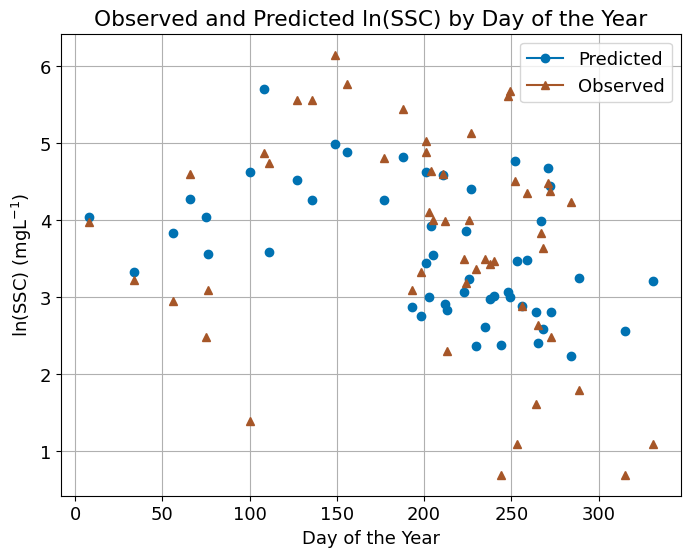

In [153]:
# Make df have datetime index

discharge_sediment['Date'] = pd.to_datetime(discharge_sediment['Date'])
fullmerge = discharge_sediment.set_index('Date')

# Extract day of the year (DOY) from the datetime index
fullmerge['DOY'] = fullmerge.index.dayofyear



In [ ]:
# This is to just plot observed & predicted by DOY alone, no discharge plot
# Can change to do ln(SSC) or regular, just change labels as needed

#plt.figure(figsize=(8,6))
#plt.plot(fullmerge['DOY'], fullmerge['lnSSC_predicted'], marker='o', color=colorblind_colors[0])
#plt.plot(fullmerge['DOY'], fullmerge['ln_Concentration'], marker='^', color=colorblind_colors[5])
#plt.plot(median_discharge_by_doy.index, median_discharge_by_doy.values, marker='o', linestyle='-', color='red', label='Median Discharge')
#plt.xlabel('Day of the Year')
#plt.ylabel('ln(SSC) (mgL$^{-1}$)')
#plt.title('Observed and Predicted ln(SSC) by Day of the Year')
#plt.grid(True)
#plt.legend(['Predicted', 'Observed'])
#plt.show()


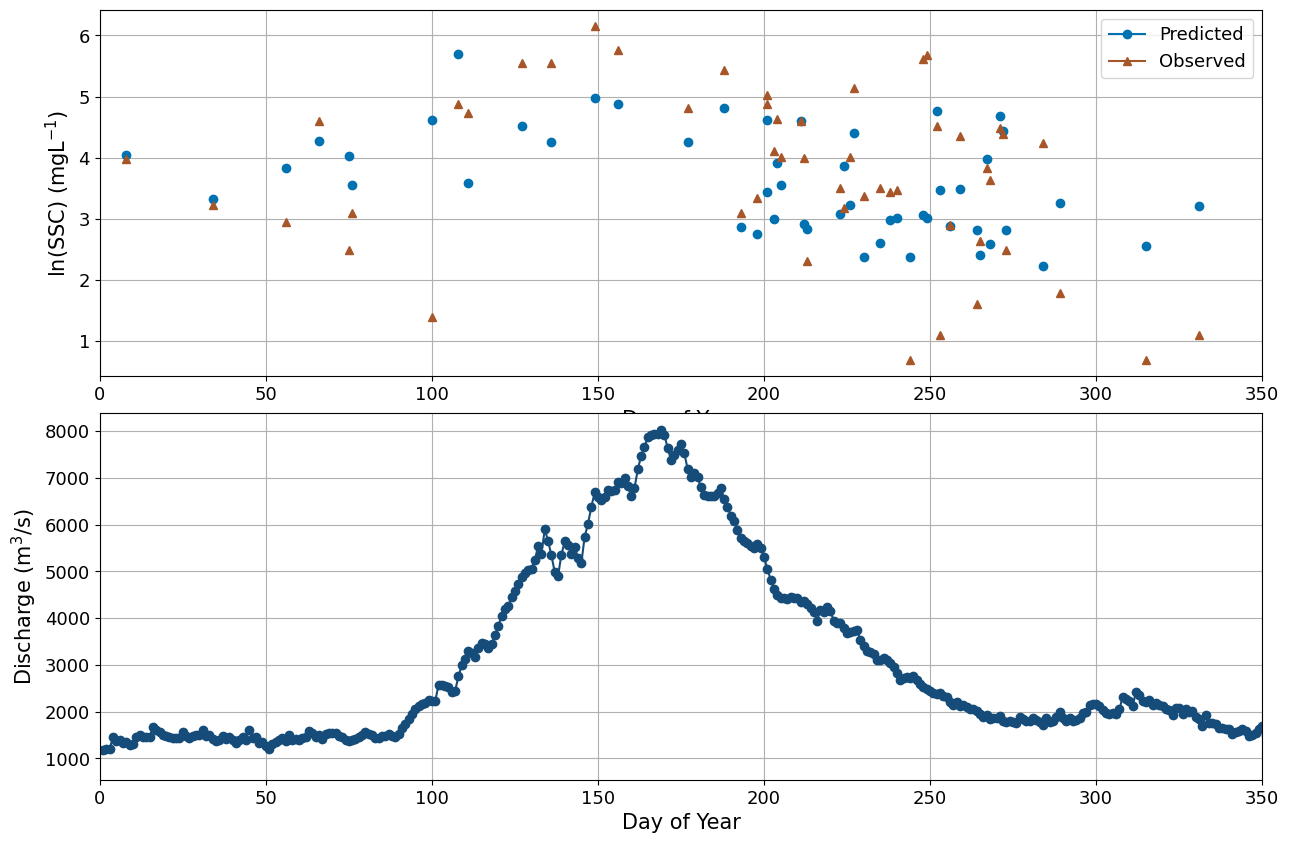

In [173]:
# Plot SSC values by day of the year with discharge plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))

# 1st plot, predicted and observed ln(SSC)
ax1.plot(fullmerge['DOY'], fullmerge['lnSSC_predicted'], marker='o', color=colorblind_colors[0], label='ln(SSC) (mgL$^{-1}$)') # put dollar signs only around text you want
ax1.plot (fullmerge['DOY'], fullmerge['ln_Concentration'], marker='^', color=colorblind_colors[5])
ax1.set_xlabel('Day of Year', fontsize=15)
ax1.set_ylabel(r'ln(SSC) (mgL$^{-1}$)', color='black', fontsize=15)
ax1.set_xlim(0, 350)
ax1.grid(True)
ax1.legend(['Predicted', 'Observed'])

# 2nd plot, median discharge over DOY
ax2.plot(median_discharge_by_doy.index, median_discharge_by_doy.values, marker='o', linestyle='-', color='#154c79', label='Median Discharge')
ax2.set_ylabel(r'Discharge (m$^{3}$/s)', color='black', fontsize=15)
ax2.set_xlabel('Day of Year', fontsize=15)
ax2.set_xlim(0, 350)

plt.subplots_adjust(hspace=0.1)

plt.grid(True)
plt.show()

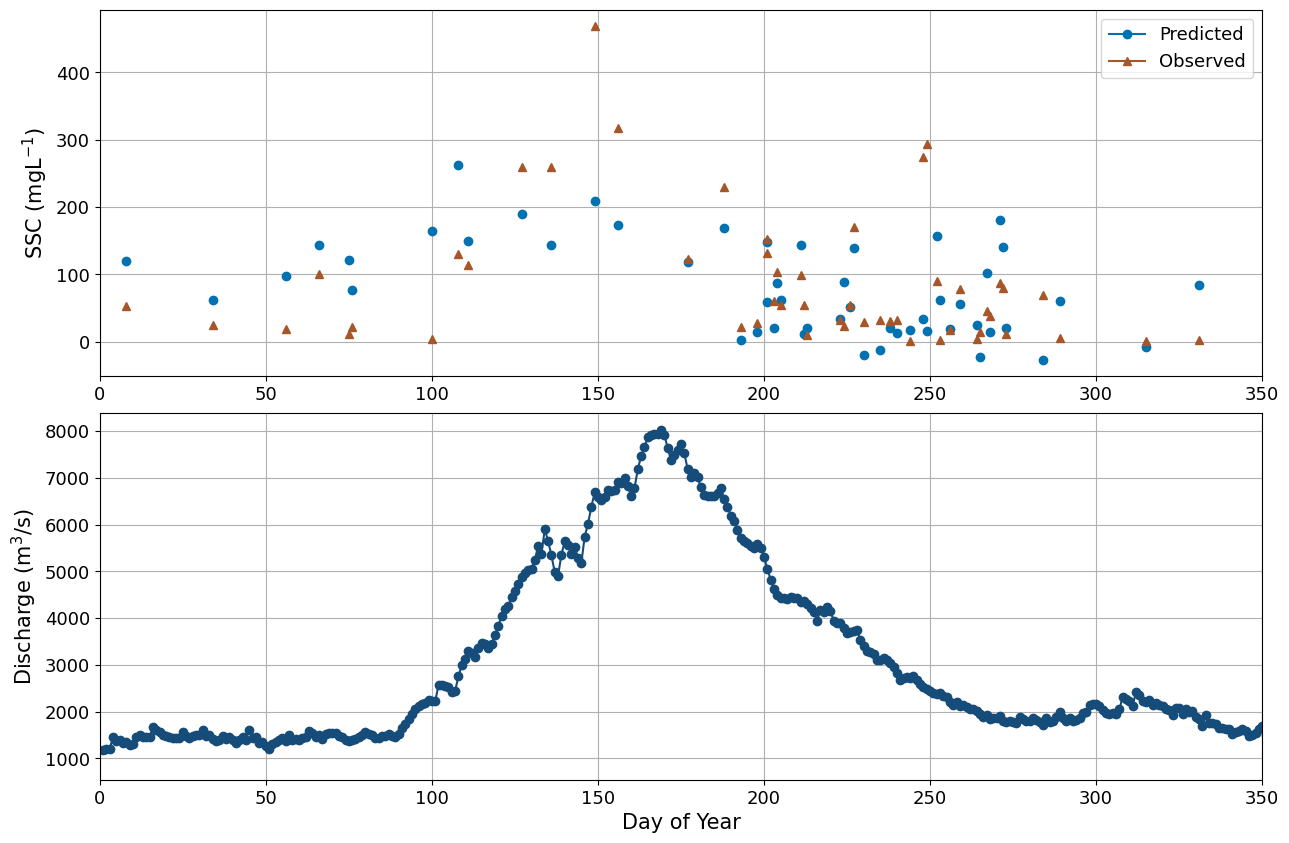

In [183]:
# Again w normal SSC values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))

# 1st plot, predicted and observed ln(SSC)
ax1.plot(fullmerge['DOY'], fullmerge['SSC_predicted'], marker='o', color=colorblind_colors[0], label='ln(SSC) (mgL$^{-1}$)') # put dollar signs only around text you want
ax1.plot (fullmerge['DOY'], fullmerge['Concentration'], marker='^', color=colorblind_colors[5])
#ax1.set_xlabel('Day of Year', fontsize=15)
ax1.set_ylabel(r'SSC (mgL$^{-1}$)', color='black', fontsize=15)
ax1.set_xlim(0, 350)
ax1.grid(True)
ax1.legend(['Predicted', 'Observed'])

# 2nd plot, median discharge over DOY
ax2.plot(median_discharge_by_doy.index, median_discharge_by_doy.values, marker='o', linestyle='-', color='#154c79', label='Median Discharge')
ax2.set_ylabel(r'Discharge (m$^{3}$/s)', color='black', fontsize=15)
ax2.set_xlabel('Day of Year', fontsize=15)
ax2.set_xlim(0, 350)

plt.subplots_adjust(hspace=0.1)

plt.grid(True)
plt.show()

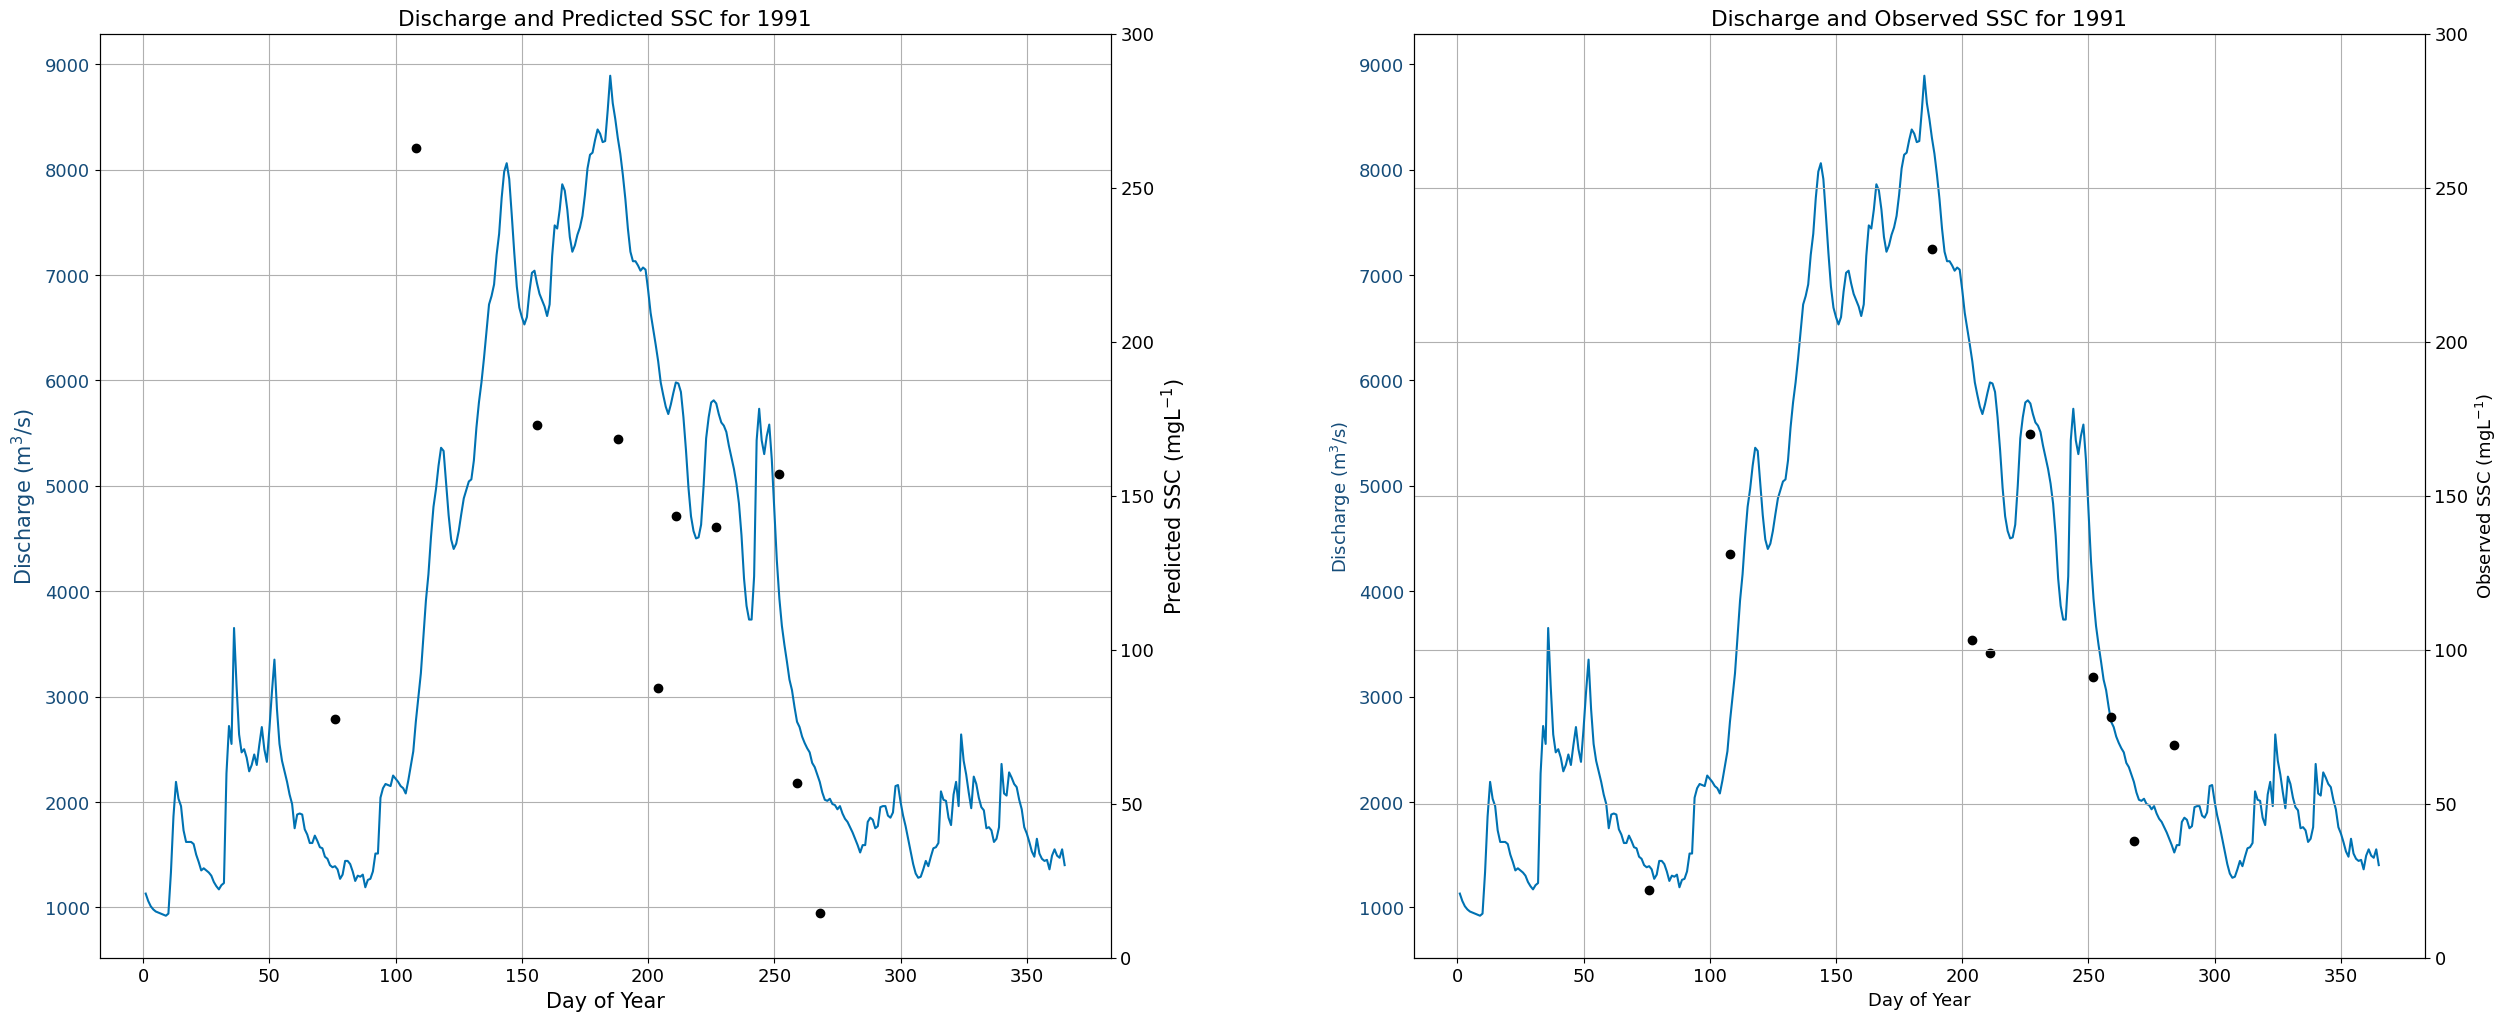

In [184]:
## Create time series plot of single year w good amount of data, discharge vs SSC, side by side plots of actual and predicted

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))

sed_discharge_91 = fullmerge[fullmerge.index.year == 1991]
sed_discharge_90 = fullmerge[fullmerge.index.year == 1990]

# Plot 1, discharge and predicted ln(SSC)
ax1.plot(sed_discharge_91['DOY'], sed_discharge_91['Value'], colorblind_colors[0], label='Discharge (m$^{3}$/s)') # put dollar signs only around text you want
ax1.set_xlabel('Day of Year', fontsize=15)
ax1.set_ylabel(r'Discharge (m$^{3}$/s)', color='#154c79', fontsize=15)
ax1.tick_params('y', labelcolor='#154c79')
ax1.grid(True)
ax1.xaxis.grid(True) # was having trouble with double grid lines, this allows the first plot to have both vertical and horizontal grid lines

ax1_ssc = ax1.twinx() # twinx allows us to have two y-axes on one x-axis, and we define the second axis name
ax1_ssc.scatter(sed_discharge_91['DOY'], sed_discharge_91['SSC_predicted'], color='black', label='SSC$_{predicted}$) mgL$^{-1}$')
ax1_ssc.set_ylabel(r'Predicted SSC (mgL$^{-1}$)', color='black', fontsize=15)
ax1_ssc.tick_params('y', labelcolor='black')
ax1_ssc.set_ylim(0, 300) # Adjust limits
ax1_ssc.grid(False) # prevents double grid lines

ax1.set_title('Discharge and Predicted SSC for 1991')

# Plot 2, discharge and observed ln(SSC)
ax2.plot(sed_discharge_91['DOY'], sed_discharge_91['Value'], colorblind_colors[0], label='Discharge (m$^{3}$/s)') # put dollar signs only around text you want
ax2.set_xlabel('Day of Year')
ax2.set_ylabel(r'Discharge (m$^{3}$/s)', color='#154c79')
ax2.tick_params('y', labelcolor='#154c79')
ax2.xaxis.grid(True) # this allows the second plot to have vertical lines, the first plot's ax1.grid already gives it horizontal lines

ax2_ssc = ax2.twinx()
ax2_ssc.scatter(sed_discharge_91['DOY'], sed_discharge_91['Concentration'], color='black', label='SSC$_{observed}$ mgL$^{-1}$')
ax2_ssc.set_ylabel(r'Observed SSC (mgL$^{-1}$)', color='black')
ax2_ssc.tick_params('y', labelcolor='black')
ax2_ssc.set_ylim(0, 300)  # Adjust limits
ax2_ssc.grid(False) # prevents double grid lines

ax2.set_title('Discharge and Observed SSC for 1991')

plt.subplots_adjust(wspace=0.3) # adding a little space between both plots so labels don't overlap

#fig.legend(loc='upper right')
plt.grid(True)
plt.show()